Mostly coppied from https://github.com/lsst/rubin_scheduler/blob/main/rubin_scheduler/scheduler/surveys/ddf_presched.py

Using `rubin_scheduler`, should be able to install everything needed with:

    conda install -c conda-forge rubin-scheduler
    scheduler_download_data

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import os

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler.utils import scheduled_observation
from rubin_scheduler.utils import calc_season, ddf_locations, survey_start_mjd
from rubin_scheduler.site_models import Almanac

from scipy.stats import binned_statistic

from astropy.time import Time

In [2]:
# Data file containing handy depths over time for each DDF location. 
# This gets downloaded with the scheduler_download_data command.
data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")
ddf_data = np.load(data_file)
ddf_grid = ddf_data["ddf_grid"].copy()
ddf_data.close()

# Load up the locations of the DDFs
ddfs = ddf_locations()
ddfs

{'ELAISS1': (9.45, -44.0),
 'XMM_LSS': (35.708333, -4.75),
 'ECDFS': (53.125, -28.1),
 'COSMOS': (150.1, 2.1819444444444445),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6)}

In [3]:
print(ddf_grid)

[(59560.2       , -0.63878697, 59560.332126  , 1.87806462, 20.37530221, 23.4043996 , 1.58073154, 20.33989545, 23.5628207 , 1.10840085, 20.96069667, 24.19286477, 3.24779407,         nan,         nan, 1.11290969, 21.08211498, 24.24670622, 1.08282637, 21.1223122 , 24.28990426)
 (59560.21041667, -0.63346487, 59560.33213486, 2.02792796, 20.60595477, 23.43391248, 1.69409615, 20.58254611, 23.61090083, 1.14108744, 21.16347017, 24.26270774, 2.78094257, 20.44678077, 22.99102926, 1.13285313, 21.28566312, 24.32635956, 1.0988619 , 21.32615497, 24.37229843)
 (59560.22083333, -0.62399475, 59560.33212362, 2.20678149, 20.8097976 , 23.43852339, 1.83287789, 20.81070785, 23.63951929, 1.17957691, 21.35335944, 24.3215756 , 2.44111724, 20.73522971, 23.2872046 , 1.15640057, 21.46854152, 24.39269844, 1.1182692 , 21.50565488, 24.43972994)
 ...
 (74170.1687466 , -0.62909172, 74170.3321128 , 1.55714723, 22.03527819, 24.36829291, 1.34952862, 22.01523636, 24.49696015, 1.04068958, 22.29501426, 24.85244401, 6.6737447

In [4]:
# Can see the grid has MJD, and then airmass, sky brightness, amd g-band 5-sigma limiting depth per ddf
# Note the depth is assuming some nominal constant seeing (probably 0.7 arcsec at zenith)
# Also the sun altitude at each timestep, as well as the next sunrise twilight start.
ddf_grid.dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('sun_n18_rising_next', '<f8'), ('ELAISS1_airmass', '<f8'), ('ELAISS1_sky_g', '<f8'), ('ELAISS1_m5_g', '<f8'), ('XMM_LSS_airmass', '<f8'), ('XMM_LSS_sky_g', '<f8'), ('XMM_LSS_m5_g', '<f8'), ('ECDFS_airmass', '<f8'), ('ECDFS_sky_g', '<f8'), ('ECDFS_m5_g', '<f8'), ('COSMOS_airmass', '<f8'), ('COSMOS_sky_g', '<f8'), ('COSMOS_m5_g', '<f8'), ('EDFS_a_airmass', '<f8'), ('EDFS_a_sky_g', '<f8'), ('EDFS_a_m5_g', '<f8'), ('EDFS_b_airmass', '<f8'), ('EDFS_b_sky_g', '<f8'), ('EDFS_b_m5_g', '<f8')])

In [5]:
mjd_start = survey_start_mjd()
print("survey start: MJD",mjd_start,"= UT",Time(mjd_start,format='mjd').iso)

survey start: MJD 60796.0 = UT 2025-05-01 00:00:00.000


In [6]:
ddf_name = "COSMOS"
season_start_offset = 160
season_end_offset = 450

# don't need to edit these
long_m5_limit = 23.0
short_m5_limit = 24.0
n_high_cadence = 43

Text(0, 0.5, '5-sigma depth in g')

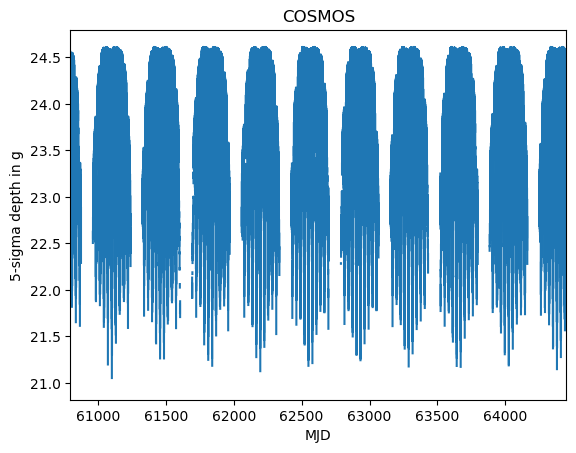

In [7]:
# Let's look at the depths over time for one DDF
fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name],'-')
ax.set_xlim([mjd_start,mjd_start+3653])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

In [8]:
# assign an integer night to each MJD value
almanac = Almanac(mjd_start=survey_start_mjd())
almanac_indx = almanac.mjd_indx(ddf_grid["mjd"])
night = almanac.sunsets["night"][almanac_indx]

# Let's cut down the DDF array to only be 1 years long
indx = np.where((night >= season_start_offset) & (night < season_end_offset))
night = night[indx]
ddf_grid = ddf_grid[indx]

# Let's say we want to observe every night where the depth is
# above some floor.
m5_limit = long_m5_limit
bins = np.arange(np.min(night), np.max(night)+2, 1) - 0.5
finite_indx = np.isfinite(ddf_grid["%s_m5_g" % ddf_name])
deepest_per_night, bin_edges, bin_n = binned_statistic(night[finite_indx],
                                                       ddf_grid["%s_m5_g" % ddf_name][finite_indx],
                                                       statistic=np.nanmax,
                                                       bins=bins)
binned_night = (bin_edges[0:-1] + bin_edges[1:])/2
nights_flag = np.zeros(binned_night.size)
# Loop over each night. If we meet the depth limit, mark it as a night to do a sequence
for i in np.arange(binned_night.size-1)+1:
    if (deepest_per_night[i] > m5_limit):
        nights_flag[i] = 1

nights_to_observe = binned_night[np.where(nights_flag == 1)]

# Could replace the above with any sort of logic you want for which nights 
# You want to observe a DDF


In [9]:

# Some basic limits.  See help(scheduled_observation) for details on these
flush_length = 2. # Days
expt = 30.  # Seconds
mjd_tol = 0.1 # Days
dist_tol = np.radians(2.)
HA_min = 21.  # Hour angle limits
HA_max = 3.
alt_min = np.radians(25.)
alt_max = np.radians(85.)
sun_alt_max = np.radians(-18.)

# How many visits to take in each filter
sequence = {'u':8, 'g': 10, 'r': 20, 'i': 20, 'z': 24, 'y': 18}
# number of snaps per visit
nsnaps = {'u':1, 'g': 1, 'r': 1, 'i': 1, 'z': 1, 'y': 1}

# now to loop over each night and generate a sequence of scheduled observations
final_observations_list = []
for obs_night in nights_to_observe:
    in_night = np.where((night == obs_night) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name]) == True))[0]
    # find the best time in the night to launch the DDF
    # This could be made more sophisticated, e.g., check there's enough time to do the sequence,
    # or inerpolate to the best time rather than using the nearest timestep, etc.
    indx = np.min(np.where(ddf_grid["%s_m5_g" % ddf_name][in_night] == np.max(ddf_grid["%s_m5_g" % ddf_name][in_night])))
    mjd = ddf_grid["mjd"][in_night[indx]]
    
    for filtername in sequence:
        for i in np.arange(sequence[filtername]):
            # Make a new empty observation
            obs = scheduled_observation()
            # fill in all the relevant info for it
            obs["RA"] = np.radians(ddfs[ddf_name][0])
            obs["dec"] = np.radians(ddfs[ddf_name][1])
            obs["mjd"] = mjd
            obs["flush_by_mjd"] = mjd + flush_length
            obs["exptime"] = expt
            obs["filter"] = filtername
            obs["nexp"] = nsnaps[filtername]
            obs["note"] = "DD:%s" % ddf_name
            obs["target"] = ddf_name

            obs["mjd_tol"] = mjd_tol
            obs["dist_tol"] = dist_tol
            # Need to set something for HA limits
            obs["HA_min"] = HA_min
            obs["HA_max"] = HA_max
            obs["alt_min"] = alt_min
            obs["alt_max"] = alt_max
            obs["sun_alt_max"] = sun_alt_max
            final_observations_list.append(obs)
                        
final_observations = np.concatenate(final_observations_list)
print()
print("season length",np.max(final_observations["mjd"]) - np.min(final_observations["mjd"]),"days")

final_observations


season length 272.60416660319606 days


array([(0, 2.61973921, 0.03808211, 60965.36666634, 60967.36666634, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 60965.36666634, 60967.36666634, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 60965.36666634, 60967.36666634, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       ...,
       (0, 2.61973921, 0.03808211, 61237.97083294, 61239.97083294, 30., 'y', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 61237.97083294, 61239.97083294, 30., 'y', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 

This array can be passed into the scheduler and simulated.

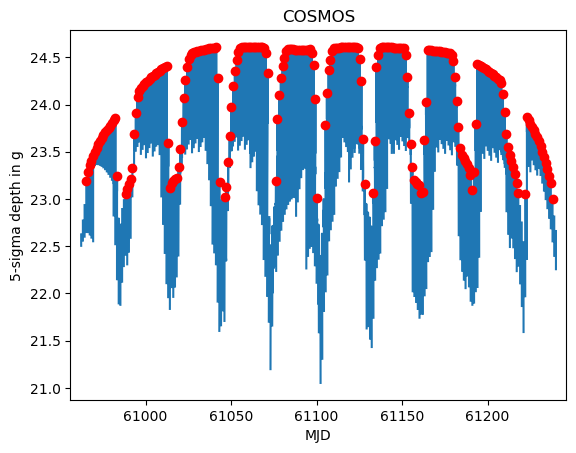

In [10]:
# Let's plot up where the final scheduled results actually landed:
final_mjd = np.unique(final_observations["mjd"])
depths = np.interp(final_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(final_mjd, depths, 'ro')
long_mjd = final_mjd.copy()
long_depths = depths.copy()

In [11]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
print('number:',len(final_mjd))
print(final_mjd)

MJD midpoint:  61101.668749641096
season length:  272.60416660319606
MJD start:  60965.3666663395
MJD end:    61237.970832942694
 
number: 253
[60965.36666634 60966.35624967 60967.35624967 60968.35624967
 60969.35624967 60970.35624967 60971.35624967 60972.35624967
 60973.35624967 60974.35624967 60975.35624967 60976.35624967
 60977.35624967 60978.35624967 60979.35624967 60980.345833
 60981.345833   60982.345833   60983.35624967 60988.35624967
 60989.35624967 60990.35624967 60991.345833   60992.345833
 60993.345833   60994.345833   60995.33541633 60996.33541633
 60997.33541633 60998.33541633 60999.33541633 61000.33541633
 61001.33541633 61002.33541633 61003.33541633 61004.33541633
 61005.33541633 61006.33541633 61007.33541633 61008.33541633
 61009.33541633 61010.33541633 61011.33541633 61012.33541633
 61013.34583299 61014.34583299 61015.34583299 61016.34583299
 61017.34583299 61018.34583299 61019.34583299 61020.33541633
 61021.33541633 61022.33541633 61023.33541633 61024.33541633
 61025.

In [12]:
# Let's say we want to observe every night where the depth is
# above some floor.
m5_limit = short_m5_limit
bins = np.arange(np.min(night), np.max(night)+2, 1) - 0.5
finite_indx = np.isfinite(ddf_grid["%s_m5_g" % ddf_name])
deepest_per_night, bin_edges, bin_n = binned_statistic(night[finite_indx],
                                                       ddf_grid["%s_m5_g" % ddf_name][finite_indx],
                                                       statistic=np.nanmax,
                                                       bins=bins)
binned_night = (bin_edges[0:-1] + bin_edges[1:])/2
nights_flag = np.zeros(binned_night.size)
# Loop over each night. If we meet the depth limit, mark it as a night to do a sequence
for i in np.arange(binned_night.size-1)+1:
    if (deepest_per_night[i] > m5_limit):
        nights_flag[i] = 1

nights_to_observe = binned_night[np.where(nights_flag == 1)]

# Could replace the above with any sort of logic you want for which nights 
# You want to observe a DDF


In [13]:

# Some basic limits.  See help(scheduled_observation) for details on these
flush_length = 2. # Days
expt = 30.  # Seconds
mjd_tol = 0.1 # Days
dist_tol = np.radians(2.)
HA_min = 21.  # Hour angle limits
HA_max = 3.
alt_min = np.radians(25.)
alt_max = np.radians(85.)
sun_alt_max = np.radians(-18.)

# How many visits to take in each filter
sequence = {'u':8, 'g': 10, 'r': 20, 'i': 20, 'z': 24, 'y': 18}
# number of snaps per visit
nsnaps = {'u':1, 'g': 1, 'r': 1, 'i': 1, 'z': 1, 'y': 1}

# now to loop over each night and generate a sequence of scheduled observations
final_observations_list = []
for obs_night in nights_to_observe:
    in_night = np.where((night == obs_night) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name]) == True))[0]
    # find the best time in the night to launch the DDF
    # This could be made more sophisticated, e.g., check there's enough time to do the sequence,
    # or inerpolate to the best time rather than using the nearest timestep, etc.
    indx = np.min(np.where(ddf_grid["%s_m5_g" % ddf_name][in_night] == np.max(ddf_grid["%s_m5_g" % ddf_name][in_night])))
    mjd = ddf_grid["mjd"][in_night[indx]]
    
    for filtername in sequence:
        for i in np.arange(sequence[filtername]):
            # Make a new empty observation
            obs = scheduled_observation()
            # fill in all the relevant info for it
            obs["RA"] = np.radians(ddfs[ddf_name][0])
            obs["dec"] = np.radians(ddfs[ddf_name][1])
            obs["mjd"] = mjd
            obs["flush_by_mjd"] = mjd + flush_length
            obs["exptime"] = expt
            obs["filter"] = filtername
            obs["nexp"] = nsnaps[filtername]
            obs["note"] = "DD:%s" % ddf_name
            obs["target"] = ddf_name

            obs["mjd_tol"] = mjd_tol
            obs["dist_tol"] = dist_tol
            # Need to set something for HA limits
            obs["HA_min"] = HA_min
            obs["HA_max"] = HA_max
            obs["alt_min"] = alt_min
            obs["alt_max"] = alt_max
            obs["sun_alt_max"] = sun_alt_max
            final_observations_list.append(obs)
                        
final_observations = np.concatenate(final_observations_list)
print()
print("season length",np.max(final_observations["mjd"]) - np.min(final_observations["mjd"]),"days")

final_observations


season length 213.6354166169258 days


array([(0, 2.61973921, 0.03808211, 60995.33541633, 60997.33541633, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 60995.33541633, 60997.33541633, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 60995.33541633, 60997.33541633, 30., 'u', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       ...,
       (0, 2.61973921, 0.03808211, 61208.97083295, 61210.97083295, 30., 'y', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 0.03808211, 61208.97083295, 61210.97083295, 30., 'y', 0., 0., 0., 0., 1, 'DD:COSMOS', 'COSMOS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 2.61973921, 

This array can be passed into the scheduler and simulated.

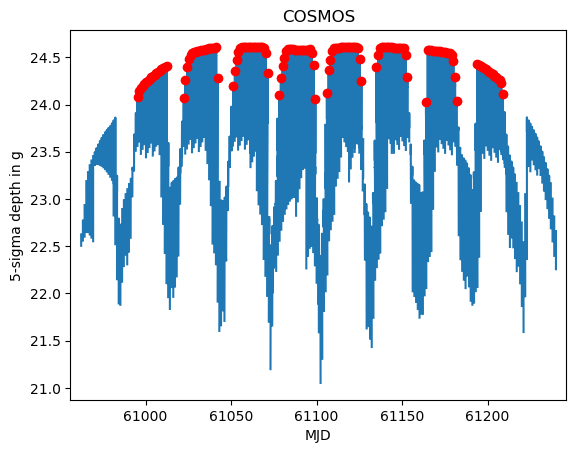

In [14]:
# Let's plot up where the final scheduled results actually landed:
final_mjd = np.unique(final_observations["mjd"])
depths = np.interp(final_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(final_mjd, depths, 'ro')

In [15]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
print('number:',len(final_mjd))
print(final_mjd)

MJD midpoint:  61102.15312464099
season length:  213.6354166169258
MJD start:  60995.33541633252
MJD end:    61208.970832949446
 
number: 157
[60995.33541633 60996.33541633 60997.33541633 60998.33541633
 60999.33541633 61000.33541633 61001.33541633 61002.33541633
 61003.33541633 61004.33541633 61005.33541633 61006.33541633
 61007.33541633 61008.33541633 61009.33541633 61010.33541633
 61011.33541633 61012.33541633 61022.33541633 61023.33541633
 61024.33541633 61025.32499966 61026.33541633 61027.33541633
 61028.33541632 61029.33541632 61030.33541632 61031.33541632
 61032.33541632 61033.33541632 61034.33541632 61035.32499966
 61036.32499966 61037.32499966 61038.32499966 61039.32499966
 61040.32499966 61041.32499966 61042.35624965 61051.17916632
 61052.19999965 61053.25208299 61054.27291632 61055.27291632
 61056.29374965 61057.29374965 61058.28333298 61059.28333298
 61060.28333298 61061.28333298 61062.27291632 61063.27291632
 61064.27291632 61065.26249965 61066.26249965 61067.26249965
 610

In [16]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
cadence = len(final_mjd)//n_high_cadence
print('cadence: ',cadence)
n_at_cadence = len(final_mjd[::cadence])
print('number near',n_high_cadence,': ',n_at_cadence)
print(final_mjd[::cadence])

ncut = ((n_at_cadence - n_high_cadence) // 2)*cadence
if (ncut < 0): ncut = 1
print(' ')
out_mjd = final_mjd[ncut:-ncut:cadence]
print('forced to ',n_high_cadence,' :',len(out_mjd))
print('high season length:',out_mjd[-1]-out_mjd[0])
print(out_mjd)

MJD midpoint:  61102.15312464099
season length:  213.6354166169258
MJD start:  60995.33541633252
MJD end:    61208.970832949446
 
cadence:  3
number near 43 :  53
[60995.33541633 60998.33541633 61001.33541633 61004.33541633
 61007.33541633 61010.33541633 61022.33541633 61025.32499966
 61028.33541632 61031.33541632 61034.33541632 61037.32499966
 61040.32499966 61051.17916632 61054.27291632 61057.29374965
 61060.28333298 61063.27291632 61066.26249965 61069.26249965
 61078.09583298 61081.15833298 61084.21041631 61087.21041631
 61090.19999964 61093.18958298 61096.17916631 61099.31458297
 61108.07499964 61111.13749964 61114.13749964 61117.12708297
 61120.1166663  61123.10624964 61126.22083297 61137.04374963
 61140.06458297 61143.0541663  61146.04374963 61149.03333296
 61152.0854163  61164.99166629 61167.99166629 61170.98124962
 61173.98124962 61176.98124962 61179.98124962 61193.97083295
 61196.97083295 61199.97083295 61202.97083295 61205.97083295
 61208.97083295]
 
forced to  43  : 43
high 

In [17]:
extend_early = np.where(long_mjd < out_mjd[0])
early = long_mjd[extend_early]
nearly = len(early)
print('number of early points: ',nearly)
# 10, 50, and 80% points in the extension
early_indices = (np.array([0.1,0.5,0.8])*nearly).astype(int)
print('early_indices: ',early_indices)
print('appending: ',early[early_indices])
out_mjd = np.concatenate((early[early_indices], out_mjd))

extend_late = np.where(long_mjd > out_mjd[-1])
late = long_mjd[extend_late]
nlate = len(late)
print('number of late points: ',nlate)
# 10, 50, and 80% points in the extension (flipped to 0.2, 0.5, 0.9)
late_indices = (np.array([0.2,0.5,0.9])*nlate).astype(int)
print('late_indices: ',late_indices)
print('appending: ',late[late_indices])
out_mjd = np.concatenate((out_mjd,late[late_indices]))

print('total number of epochs should be ',n_high_cadence+6,': ',len(out_mjd))
print('final season length: ',out_mjd[-1] - out_mjd[0])
out_mjd

number of early points:  41
early_indices:  [ 4 20 32]
appending:  [60969.35624967 60989.35624967 61001.33541633]
number of late points:  41
late_indices:  [ 8 20 36]
appending:  [61202.97083295 61214.96041628 61233.97083294]
total number of epochs should be  49 :  49
final season length:  264.61458327172295


array([60969.35624967, 60989.35624967, 61001.33541633, 61010.33541633,
       61022.33541633, 61025.32499966, 61028.33541632, 61031.33541632,
       61034.33541632, 61037.32499966, 61040.32499966, 61051.17916632,
       61054.27291632, 61057.29374965, 61060.28333298, 61063.27291632,
       61066.26249965, 61069.26249965, 61078.09583298, 61081.15833298,
       61084.21041631, 61087.21041631, 61090.19999964, 61093.18958298,
       61096.17916631, 61099.31458297, 61108.07499964, 61111.13749964,
       61114.13749964, 61117.12708297, 61120.1166663 , 61123.10624964,
       61126.22083297, 61137.04374963, 61140.06458297, 61143.0541663 ,
       61146.04374963, 61149.03333296, 61152.0854163 , 61164.99166629,
       61167.99166629, 61170.98124962, 61173.98124962, 61176.98124962,
       61179.98124962, 61193.97083295, 61202.97083295, 61214.96041628,
       61233.97083294])

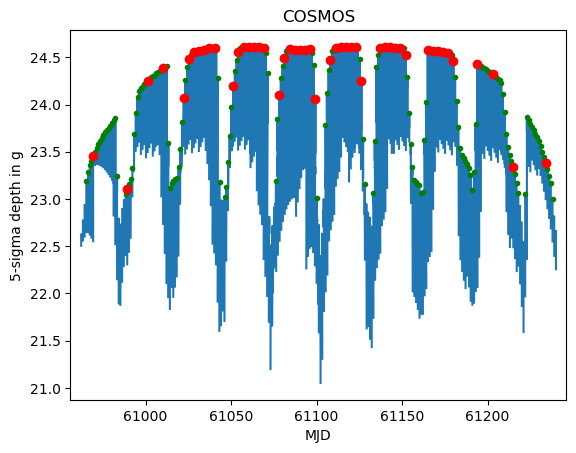

In [18]:
# Let's plot up where the final scheduled results actually landed:
depths = np.interp(long_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
outdepths = np.interp(out_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(long_mjd, long_depths, 'g.')
ax.plot(out_mjd, outdepths, 'ro')
plt.savefig('uniform-longseason-%s.png' % ddf_name, dpi=150, bbox_inches='tight')
plt.show()